In [80]:
!pip install box2d

In [81]:
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import base64, io
import numpy as np
from collections import deque, namedtuple
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [82]:
env = gym.make("LunarLander-v2")
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [83]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size) 
    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

In [84]:
Size_ofbuffer = int(1e5)  
Size_ofbatch = 64         
disc_f = 0.99            
TAU = 1e-3              
alpha = 5e-4               
freq_upd = 4        

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [86]:
class Agent():
    

    def __init__(self, state_size, action_size, seed):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_original = QNetwork(state_size, action_size, seed).to(device)
        self.target_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_original.parameters(), lr=alpha)

        # Replay buffer
        self.buffer = ReplayBuffer(action_size, Size_ofbuffer, Size_ofbatch, seed)
        # Initialize time step (for updating every freq_upd steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay buffer
        self.buffer.add(state, action, reward, next_state, done)
        
        # Learn every freq_upd time steps.
        self.t_step = (self.t_step + 1) % freq_upd
        if self.t_step == 0:
            # If enough samples are available in buffer, get random subset and learn
            if len(self.buffer) > Size_ofbatch:
                experiences = self.buffer.sample()
                self.learn(experiences, disc_f)

    def act(self, state, eps=0.):
       
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_original.eval()
        with torch.no_grad():
            action_values = self.qnetwork_original(state)
        self.qnetwork_original.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, disc_f):
       
        # Obtain random minibatch of tuples from D
        states, actions, rewards, next_states, dones = experiences

        ## Compute and minimize the loss
        ### Extract next maximum estimated value from target network
        q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        ### Calculate target value from bellman equation
        q_targets = rewards + disc_f * q_targets_next * (1 - dones)
        ### Calculate expected value from local network
        q_expected = self.qnetwork_original(states).gather(1, actions)
        
        ### Loss calculation (we used Mean squared error)
        loss = F.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_original, self.target_network, TAU)                     

    def soft_update(self, local_model, target_model, tau):
      for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
       

In [87]:
class ReplayBuffer:
  

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of intersl memory."""
        return len(self.memory)

In [88]:
def dqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []                       
    scores_window = deque(maxlen=100)  
    eps = eps_start                    
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)      
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) 
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=250.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_origisl.state_dict(), 'checkpoint.pth')
            break
    return scores
  

agent = Agent(state_size=8, action_size=4, seed=0)
scores = dqn()

Episode 100	Average Score: -138.26
Episode 200	Average Score: -103.24
Episode 300	Average Score: -56.90
Episode 400	Average Score: -2.09
Episode 500	Average Score: 119.07
Episode 600	Average Score: 220.84
Episode 700	Average Score: 217.76
Episode 800	Average Score: 204.73
Episode 900	Average Score: 182.40
Episode 1000	Average Score: 205.63


In [89]:
average = []
window = 250
for i in range(len(scores)-250):
  temp = np.mean(scores[i:i+window])
  average.append(temp)


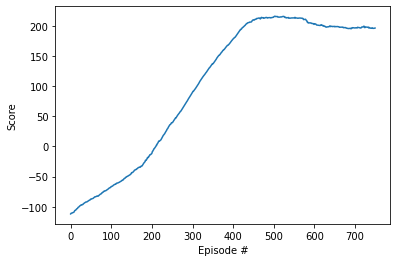

In [90]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(average)), average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()